In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

%load_ext tensorboard

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
dataset_path = os.path.join(os.getcwd(), 'Sunspots.csv')
dataset_df = pd.read_csv(dataset_path)
dataset_np = dataset_df.iloc[:,2].values

In [4]:
dataset_df.describe()

,Unnamed: 0,Monthly Mean Total Sunspot Number
count,3252.000000,3252.000000
mean,1625.500000,82.070695
std,938.915864,67.864736
min,0.000000,0.000000
25%,812.750000,24.200000
50%,1625.500000,67.750000
75%,2438.250000,122.700000
max,3251.000000,398.200000


In [5]:
len(dataset_df)

3252

In [6]:
def standardize_dataset(dataset):
    mean = np.mean(dataset)
    std = np.std(dataset)
    standardize_func = lambda x: (x - mean)/std
    destandardize_func = lambda x: x*std+mean
    return standardize_func(dataset), standardize_func, destandardize_func

In [7]:
standardized_dataset_np, standardize_func, destandardize_func = standardize_dataset(dataset_np)

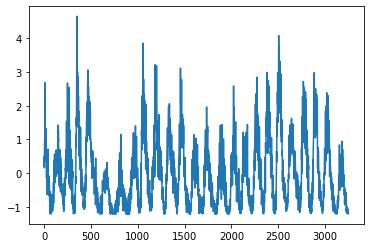

In [8]:
plt.plot(standardized_dataset_np)

In [10]:
def split_train_validation(data, valid_factor=0.3):
    split_index = int(len(data)*(1-valid_factor))
    training_dataset = data[:split_index]
    validation_dataset = data[split_index:]
    return training_dataset, validation_dataset

In [11]:
training_dataset_np, validation_dataset_np = split_train_validation(standardized_dataset_np)

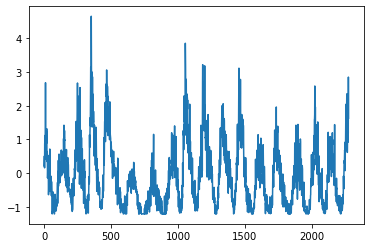

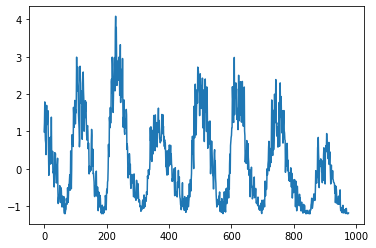

In [12]:
plt.plot(training_dataset_np)
plt.figure()
plt.plot(validation_dataset_np)

In [13]:
def windowed_dataset(series, window_size, shift, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=10)
    dataset = dataset.batch(batch_size).prefetch(5)
    return dataset

In [14]:
WINDOWS_SIZE = 32
SHIFT = 1
BATCH_SIZE = 32
training_dataset = windowed_dataset(training_dataset_np, WINDOWS_SIZE, SHIFT, BATCH_SIZE)
validation_dataset = windowed_dataset(validation_dataset_np, WINDOWS_SIZE, SHIFT, BATCH_SIZE)

In [15]:
example = next(iter(training_dataset))[0]
print(example)
example = next(iter(validation_dataset))[0]
print(example)

tf.Tensor(
[[ 0.32760348  0.51034797  0.1581227  ...  0.41897573  0.25981117
  -0.63180512]
 [ 0.51034797  0.1581227   0.87878446 ...  0.25981117 -0.63180512
  -0.63917385]
 [ 0.21559879  0.32760348  0.51034797 ...  0.03580178  0.41897573
   0.25981117]
 ...
 [ 0.88320569  0.591404    0.65477508 ...  0.25686367 -0.23684121
   0.7166724 ]
 [ 0.01811683  0.53392791  0.24654745 ... -0.74823105 -0.90739561
  -1.00761034]
 [ 0.24654745  0.25686367 -0.23684121 ... -1.00761034 -0.61706766
  -0.88528942]], shape=(32, 32), dtype=float64)
tf.Tensor(
[[ 1.2265885   1.79103319  1.07037143 ... -0.06736043 -0.40484825
  -0.48737802]
 [ 0.37918459  1.47123032  1.69818719 ...  0.26570615  0.4086595
  -0.07178167]
 [ 1.27080087  1.18679736  1.38870055 ... -0.26631613 -0.38126831
  -0.3326347 ]
 ...
 [ 0.28044361  0.12570029  0.85078328 ... -0.78654845 -0.73791483
  -0.45348187]
 [-0.17494388  0.0299068   0.25096869 ... -0.59348773 -0.93097555
  -0.77328473]
 [-0.26631613 -0.38126831 -0.3326347  ... -1.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[32]),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(32, 5, strides=1, padding='causal', activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='huber', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 32)            192       
_________________________________________________________________
bidirectional (Bidirectional (None, 32, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

In [17]:
log_dir_path = os.path.join(os.getcwd(), 'logs/fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_path)
print(log_dir_path)

/home/jan/ml_own_projects/sequential_data_projects/logs/fit


In [22]:
model.fit(training_dataset,
          validation_data=validation_dataset,
         epochs=10,
         callbacks=[tensorboard_callback])

Epoch 1/10
      2/Unknown - 0s 99ms/step - loss: 0.042WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0089s vs `on_train_batch_end` time: 0.1888s). Check your callbacks.
71/71 [==============================] - 1s 11ms/step - loss: 0.0652 - val_loss: 0.07
Epoch 2/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0648 - val_loss: 0.07
Epoch 3/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0647 - val_loss: 0.07
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0647 - val_loss: 0.07
Epoch 5/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0629 - val_loss: 0.07
Epoch 6/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0628 - val_loss: 0.07
Epoch 7/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0652 - val_loss: 0.07
Epoch 8/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0628 - val_loss: 0.07
Epoch 9/10
7

In [23]:
forecasting = np.array([])
for x, y in validation_dataset:
    predictions = model.predict(x)[:,0]
    forecasting = np.concatenate([forecasting, predictions])
forecasting = np.concatenate([np.zeros(WINDOWS_SIZE), forecasting])

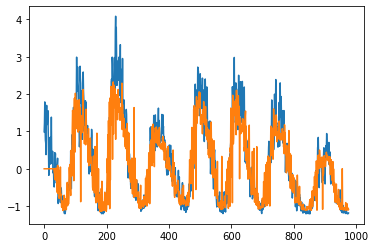

In [24]:
plt.plot(validation_dataset_np)
plt.plot(forecasting)

In [18]:
%tensorboard --logdir /home/jan/ml_own_projects/sequential_data_projects/logs/fit

Launching TensorBoard...